# Sixth exercise (Chapter 8)

In this exercise we consider Chapter 8 of the book "Deep Learning". The exercise focuses on some optimization techniques  that represent the state-of-the-art for training neural networks.
In particular, you will implement SGD with different learning rate schedules, SGD with momentum and ADAM algorithms, and use them to train a small feedforward neural network on the MNIST dataset. Fianlly, you will be asked to answer few questions about second order methods.

List of covered topics: 

* Stochastic Gradient Descent with different learning rate decay heuristics (8.3.1)
* SGD with Momentum (8.3.2)
* Adam (8.5.3)
* Newton's Method (8.6.1)

Apart from the MNIST dataset and the mnist_loader.py file, both available on ILIAS, we also need a Python library called Numpy, for doing fast linear algebra. If you don't already have Numpy installed, please install it. 

### NOTE
In order to speed up the training, reduce the training set size to the first 10000 examples.

## Code

The following code implements a feedforward neural network together with the backpropagation and SGD algorithms. In the next points of this exercise you will be asked to add some extra optimization features to this implementation. 

In [56]:
#### Libraries
# Standard library
%matplotlib inline
import pickle
import gzip
import sys
import pdb

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

def load_data():

    f = gzip.open('data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
    # training_data, validation_data, test_data = pickle.load(f)
    f.close()
    return (training_data, validation_data, test_data)

def load_datawrapper():

    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]     # flatten images to 1 dim vectors
    training_results = [vectorized_result(y) for y in tr_d[1]]       # one hot encode labels - only for training
    training_data = zip(training_inputs, training_results)           # make list of tuples inputs / label
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_results = [vectorized_result(y) for y in va_d[1]]     # one hot encode labels - only for training
    validation_data = zip(validation_inputs, validation_results[1])  #  also flattened inputs, but lables not one hot encoded
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_results = [vectorized_result(y) for y in te_d[1]]     # one hot encode labels - only for training   
    test_data = zip(test_inputs, test_results[1])
    return (list(training_data), list(validation_data), list(test_data))

def vectorized_result(j):

    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [87]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

def vectorized_result(j):   #  one-hot encode
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# Define the Quadratic and the Cross-Entropy cost functions

class QuadraticCost(object):

    @staticmethod
    def fn(a, y):
        return 0.5*np.linalg.norm(a-y)**2
        
    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)

class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):    # bernoully or multinoulli distribution: y € {0,1}
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod    # gradient after math short-cut
    def delta(z, a, y):
        return (a-y)



class Constant(object):   # Learning Rate Schedule
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 0.1, lr_min = 1e-9):   # return list len=nepochs with variing learning rates
        '''lr_0: initial value of the learning rate
           stepsize: length of step size (to be used only with CosineDecayRestart and Step classes)
           nepochs: total number of epochs
           
           the function should return a list of length=nepochs where element i is the value of the learning rate
           at epoch i 
        '''
        learning_rates = [lr_0 for number in range(nepochs)]
        return learning_rates
        
class Step(object):
    
    def lr(lr_0, stepsize, nepochs, factor = 2.0, lr_min = 1e-9):
        # reduce the learning rate by a factor each stepsize steps
        learning_rates = []
        lr = lr_0
        for epoch in range(nepochs):
            learning_rates.append(lr)            
            if epoch % stepsize == 0:
                lr = lr * factor
        return learning_rates

class Linear(object):
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 1.1, lr_min = 1e-9):
        learning_rates = []
        # set_trace()
        lr = lr_0
        for epoch in range(nepochs):
            learning_rates.append(lr)
            lr = lr * factor            
        return learning_rates        
        # learning_rates = [lr / factor for i range(nepochs)]
    
class CosineDecay(object):
    
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 0.1, lr_min = 1e-9):
        
        learning_rates = []
        lr = lr_0        
        for epoch in range(nepochs):    # from Ilya Loshchilov & Frank Hutter paper
            lr = lr_min + 0.5 * (lr_0 - lr_min) * (1 + np.cos((epoch / (nepochs-1) * np.pi)))
            learning_rates.append(lr)
        return learning_rates  

    
class CosineDecayRestart(object):
    
    # perform several runs with restarts. After one run with stepsize steps, lr returns to  
    # lr 
    @staticmethod
    def lr(lr_0, stepsize, nepochs, factor = 2.0, lr_min = 1e-9):

        learning_rates = []
        lr = lr_0
        stepsize_f = stepsize     
        epoch_in_run = 0
        last_at_mu_min = 0
        # set_trace()
        for epoch in range(nepochs):
            if (epoch_in_run == stepsize): 
                epoch_in_run = 0       # start new run when reach stepsize
                stepsize_f *= factor   # allow for non discrete factors for flexibility
                stepsize = int(stepsize_f)  # set actual stepsize to integer number
                # stepsize = int(stepsize*factor)     # each run gets longer then previous by factor t_mult
                # last_restart = epoch   # memorise the index (epoch) of last restart
                

            # at new run lr returns to = lr_0. Then decay during run. 
            # At end of run (nepochs_in_run = stepsize) lr = lr_min
            lr = lr_min + 0.5 * (lr_0 - lr_min) * (1 + np.cos(epoch_in_run / max(stepsize-1,1) * np.pi))

            epoch_in_run += 1      # continue run
            
            learning_rates.append(lr)
            
            if epoch_in_run == stepsize - 1:
                last_at_mu_min = epoch + 1   # memorise index of last epoch before restart (at mu_min)
            
        # according to Loshchilov & Hutter and intuitively at the epochs after the restarts 
        # results might worsen (starting with large l_rates)
        # the recommended solution is, to take the last epoch (= smallest learning_rate) of the last "sub-runs",
        if last_at_mu_min > 0:
            del learning_rates[last_at_mu_min+1:]
            
        return learning_rates        

class Network(object):

    def __init__(self, sizes, cost=QuadraticCost, lr_schedule=Constant):

        self.num_layers = len(sizes)
        self.sizes = sizes   
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]  
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost
        self.lr_schedule = lr_schedule

    def feedforward(self, a):

        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, 
            stepsize=1, lr_0=0.1, factor=0.8, lr_min = 1e-9,
            momentum=False,
            alpha=0,
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            filename_config=None,
            filename_results=None):
        # set_trace()  
        n_data = 0
        if evaluation_data: 
            n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        
        lr_list = self.lr_schedule.lr(lr_0, stepsize, epochs, factor = factor, lr_min = lr_min)

        print("generated lr_list \n{}".format(lr_list))
     
        for j in range(len(lr_list)):  # in case of CosineDecayRestart shorter than epochs
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr_list[j], momentum , alpha)
                
            print ("Epoch {0} complete".format(j))
            
            if monitor_training_cost:
                cost = self.total_cost(training_data)
                training_cost.append(cost)
                print ("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data)
                training_accuracy.append(accuracy)
                print ("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data)
                evaluation_cost.append(cost)
                print ("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))   
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy, lr_list

    def update_mini_batch(self, mini_batch, eta, momentum, alpha):
    
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        if momentum:
            
            #TODO:momentum
            raise NotImplementedError 
        
        else:
            
            self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
            self.biases = [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)] 
    

    def Adam(self, training_data, epochs, mini_batch_size, stepsize=1, lr_0=0.1,
            rho_1=0.9,
            rho_2=0.999,
            delta=10**(-8),
            evaluation_data=None,
            monitor_evaluation_cost=False,
            monitor_evaluation_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False,
            filename_config=None,
            filename_results=None):
      
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        lr_list = (self.lr_schedule).lr(lr_0, stepsize, epochs)
        # lr_list = self.lr_schedule.lr(lr_0, stepsize, epochs, factor = factor, lr_min = lr_min) 
        
        # initialize moment estimates
        s_b = [np.zeros(b.shape) for b in self.biases]
        s_w = [np.zeros(w.shape) for w in self.weights]
        r_b = [np.zeros(b.shape) for b in self.biases]
        r_w = [np.zeros(w.shape) for w in self.weights]  
        self.first_moment_estimates = (s_b, s_w)
        self.second_moment_estimates = (r_b, r_w)        
        
        t = 0
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            
            for mini_batch in mini_batches:
                t = t+1
                self.update_mini_batch_adam(mini_batch, lr_list[j], rho_1, rho_2, delta, t)
                
            print ("Epoch {0} complete".format(j))
            
            if monitor_training_cost:
                cost = self.total_cost(training_data)
                training_cost.append(cost)
                print ("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data)
                training_accuracy.append(accuracy)
                print ("Accuracy on training data: {} / {}".format(
                    accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data)
                evaluation_cost.append(cost)
                print ("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print ("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
        return training_cost, training_accuracy, evaluation_cost, evaluation_accuracy, lr_list

    def update_mini_batch_adam(self, mini_batch, eta, rho_1, rho_2, delta, t):
        '''
        mini_batch: the mini batch considered in the current subepoch 
        eta: value of the learning rate for the current epoch
        rho_1: Adam's parameter (see par. 8.5.3)
        rho_2: Adam's parameter (see par. 8.5.3)
        delta: Adam's correction term (see par. 8.5.3)
        t: number of gradient's updates that has been done so far
        
        the function should update the parameters of the network (self.weights and self.biases) 
        based on Adam's update rule.
        '''
        # compute gradient as usually
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # unpack moment estimates
        (s_b, s_w) = self.first_moment_estimates
        (r_b, r_w) = self.second_moment_estimates
            
        # first moment estimate
        s_b = [rho_1 * s + (1 - rho_1) * d for (s, d) in zip(s_b, nabla_b)]
        s_w = [rho_1 * s + (1 - rho_1) * d for (s, d) in zip(s_w, nabla_w)]
        
        # second moment estimate
        r_b = [rho_2 * r + (1 - rho_2) * d * d for (r, d) in zip(r_b, nabla_b)]
        r_w = [rho_2 * r + (1 - rho_2) * d * d for (r, d) in zip(r_w, nabla_w)]
        # (in numpy, ndarray multiplication is by default element-wise)
        
        # correct bias in first moment
        s_hat_b = [s / (1 - rho_1 ** t) for s in s_b]
        s_hat_w = [s / (1 - rho_1 ** t) for s in s_w]
        
        # correct bias in second moment
        r_hat_b = [r / (1 - rho_2 ** t) for r in r_b]
        r_hat_w = [r / (1 - rho_2 ** t) for r in r_w]
        
        # compute and apply update
        self.biases = [b - (eta/len(mini_batch)) * s_hat / (np.sqrt(r_hat) + delta)
                       for (b, s_hat, r_hat) in zip(self.biases, s_hat_b, r_hat_b)]
        self.weights = [w - (eta/len(mini_batch)) * s_hat / (np.sqrt(r_hat) + delta)
                        for (w, s_hat, r_hat) in zip(self.weights, s_hat_w, r_hat_w)]
        # again, all operations element-wise

        # self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        
        # save moment estimates
        self.first_moment_estimates = (s_b, s_w)
        self.second_moment_estimates = (r_b, r_w)

            
    def backprop(self, x, y):
  
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used in the following way:
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self, data):

        results = [(np.argmax(self.feedforward(x)), np.argmax(y)) for (x, y) in data]

        return sum(int(x == y) for (x, y) in results)

    def total_cost(self, data):
    
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            cost += self.cost.fn(a, y)/len(data)
        return cost 



## Stochastic Gradient Descent (SGD) with different learning rate decay heuristics

Stochastic gradient descent based algorithms represent the-state-of-the-art to train deep neural networks. As you might have experienced, and as it is stated in the book, one of the major drawbacks of these methods is their great sensitivity to the learning rate value: performances indeed change dramatically with different values of this parameter. In exercise 04 we trained an MLP with SGD using a fixed learning rate value:in general practitioners decrease it to have better performances.Implement the following different heuristics for the learning rate value: constant, step decay, linear decay, cosine decay, and cosine decay with restarts. In order to achieve this goal, follow the '#TODO:learning_rate' indications in the code. Then use each one of these heuristics to train a feedforward neural network with 2 hidden layers of 30 and 100 neurons respectively. In particular: set the initial value for the learning rate to 3.0, the stepsize to 7, and train the network for 30 epochs with a batch size of 10 on the MNIST dataset. Finally, generate two plots for each experiment: learning rate vs epochs, and test accuracy vs epochs.

In [80]:
# import mnist_loader

# training_data, validation_data, test_data = mnist_loader.load_datawrapper()
# training_data, validation_data, test_data = load_datawrapper()
original_train_data, gaga, gogo = load_datawrapper()
training_data = original_train_data[:10000]
validation_data = original_train_data[10000:11000]
test_data = original_train_data[11000:12000]
# training_data = training_data[:10000]

num_training_examples = len(training_data) 
num_validation_examples = len(validation_data)
num_test_examples = len(test_data)

num_features = len(training_data[0][0])
num_classes = len(training_data[0][1])


8000
10
10000
1000
1000


In [81]:
def lr_schedule(lr_schedule, factor=1.0):
    # set_trace()
    net = Network([num_features,30,100,num_classes], cost=QuadraticCost, lr_schedule=lr_schedule)   
    t_cost, t_accuracy, e_cost, e_accuracy, lr_list = net.SGD(training_data, 30, 10,    # epochs / batch size
                stepsize=7, lr_0=3, factor=factor, lr_min = 0.01,
                momentum = False,
                evaluation_data=test_data,
                monitor_evaluation_cost=True,
                monitor_evaluation_accuracy=True,
                monitor_training_cost=True,
                monitor_training_accuracy=True)
    return lr_list, t_accuracy

In [82]:
lr_lists = []
t_accuracies = []
lr_list, t_accuracie = lr_schedule(Constant)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(Step, factor=0.5)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(Linear, factor=0.9)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(CosineDecay)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)
lr_list, t_accuracie = lr_schedule(CosineDecayRestart, factor=2)
lr_lists.append(lr_list)
t_accuracies.append(t_accuracie)

#lr_lists[0], t_accuracies[0] = lr_schedule(Constant)
#lr_lists[1], t_accuracies[1] = lr_schedule(Step)
#lr_lists[2], t_accuracies[2] = lr_schedule(Linear)
#lr_lists[3], t_accuracies[3] = lr_schedule(Cosine)
#lr_lists[4], t_accuracies[4] = lr_schedule(Cosine)

generated lr_list 
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Epoch 0 complete
Cost on training data: 0.21237290157160374
Accuracy on training data: 6775 / 10000
Cost on evaluation data: 0.23708680225805473
Accuracy on evaluation data: 654 / 1000
Epoch 1 complete
Cost on training data: 0.16790332305528893
Accuracy on training data: 7272 / 10000
Cost on evaluation data: 0.18996120320989854
Accuracy on evaluation data: 697 / 1000
Epoch 2 complete
Cost on training data: 0.15599502409836438
Accuracy on training data: 7409 / 10000
Cost on evaluation data: 0.18230882937970852
Accuracy on evaluation data: 704 / 1000
Epoch 3 complete
Cost on training data: 0.1651400216521016
Accuracy on training data: 7355 / 10000
Cost on evaluation data: 0.1870463425647563
Accuracy on evaluation data: 703 / 1000
Epoch 4 complete
Cost on training data: 0.14069161411118836
Accuracy on training data: 7580 / 10000
Cost on evaluation data: 0.1652606853630516
Accuracy

Epoch 13 complete
Cost on training data: 0.0828442751129456
Accuracy on training data: 8613 / 10000
Cost on evaluation data: 0.12211657865805021
Accuracy on evaluation data: 816 / 1000
Epoch 14 complete
Cost on training data: 0.08206915671410889
Accuracy on training data: 8621 / 10000
Cost on evaluation data: 0.120525745931872
Accuracy on evaluation data: 819 / 1000
Epoch 15 complete
Cost on training data: 0.08046747698275968
Accuracy on training data: 8630 / 10000
Cost on evaluation data: 0.12027422900556144
Accuracy on evaluation data: 818 / 1000
Epoch 16 complete
Cost on training data: 0.08037683873520936
Accuracy on training data: 8635 / 10000
Cost on evaluation data: 0.12195269475594503
Accuracy on evaluation data: 820 / 1000
Epoch 17 complete
Cost on training data: 0.07985101180191875
Accuracy on training data: 8634 / 10000
Cost on evaluation data: 0.12107534833734387
Accuracy on evaluation data: 819 / 1000
Epoch 18 complete
Cost on training data: 0.07930445281815446
Accuracy on 

Cost on training data: 0.02522509223750281
Accuracy on training data: 9672 / 10000
Cost on evaluation data: 0.07958717202213948
Accuracy on evaluation data: 902 / 1000
Epoch 25 complete
Cost on training data: 0.025052830464896945
Accuracy on training data: 9673 / 10000
Cost on evaluation data: 0.07935967372354395
Accuracy on evaluation data: 901 / 1000
Epoch 26 complete
Cost on training data: 0.02497265329541794
Accuracy on training data: 9678 / 10000
Cost on evaluation data: 0.07924269113626076
Accuracy on evaluation data: 903 / 1000
Epoch 27 complete
Cost on training data: 0.024812284115418325
Accuracy on training data: 9679 / 10000
Cost on evaluation data: 0.07914883952771627
Accuracy on evaluation data: 903 / 1000
Epoch 28 complete
Cost on training data: 0.02478227748806362
Accuracy on training data: 9680 / 10000
Cost on evaluation data: 0.07852636691651048
Accuracy on evaluation data: 899 / 1000
Epoch 29 complete
Cost on training data: 0.024525612614945604
Accuracy on training dat

Epoch 3 complete
Cost on training data: 0.11367728182286775
Accuracy on training data: 8290 / 10000
Cost on evaluation data: 0.1358892061516364
Accuracy on evaluation data: 807 / 1000
Epoch 4 complete
Cost on training data: 0.10418183766003569
Accuracy on training data: 8378 / 10000
Cost on evaluation data: 0.13039536855287623
Accuracy on evaluation data: 809 / 1000
Epoch 5 complete
Cost on training data: 0.10081749043102428
Accuracy on training data: 8409 / 10000
Cost on evaluation data: 0.12791447047157398
Accuracy on evaluation data: 812 / 1000
Epoch 6 complete
Cost on training data: 0.10053932726454441
Accuracy on training data: 8414 / 10000
Cost on evaluation data: 0.12799086255374523
Accuracy on evaluation data: 807 / 1000
Epoch 7 complete
Cost on training data: 0.11767180025311356
Accuracy on training data: 8317 / 10000
Cost on evaluation data: 0.14164960618771819
Accuracy on evaluation data: 799 / 1000
Epoch 8 complete
Cost on training data: 0.10896292452460811
Accuracy on trai

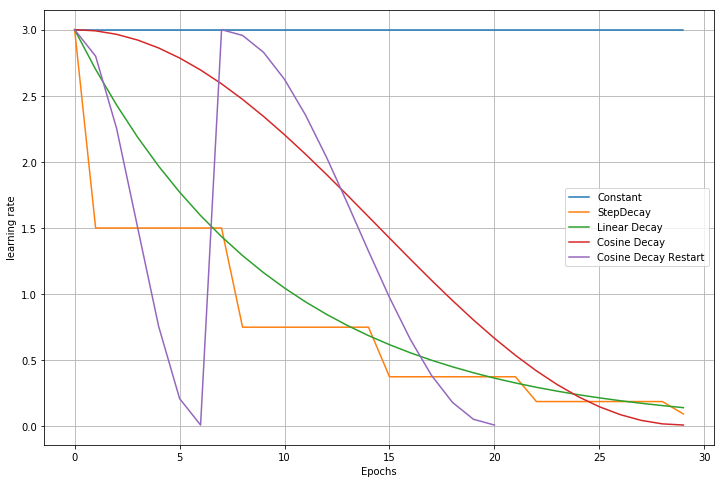

In [83]:
plt.figure(figsize=(12, 8))
plt.plot(lr_lists[0], label="Constant")
plt.plot(lr_lists[1], label="StepDecay")
plt.plot(lr_lists[2], label="Linear Decay")
plt.plot(lr_lists[3], label="Cosine Decay")
plt.plot(lr_lists[4], label="Cosine Decay Restart")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("learning rate")
plt.legend(loc='best')

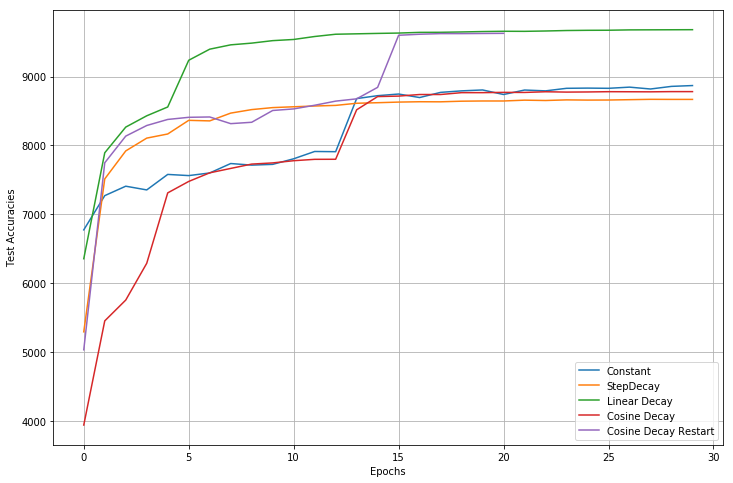

In [91]:
plt.figure(figsize=(12, 8))
plt.plot(t_accuracies[0], label="Constant")
plt.plot(t_accuracies[1], label="StepDecay")
plt.plot(t_accuracies[2], label="Linear Decay")
plt.plot(t_accuracies[3], label="Cosine Decay")
plt.plot(t_accuracies[4], label="Cosine Decay Restart")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracies")
plt.legend(loc='best')

## Momentum

In presence of an ill conditioned Hessian matrix, it might be useful to consider an exponentially decaying moving average of the past gradients in order to speed up the learning. SGD with momentum (see equations 8.15 and 8.16 in the book) has indeed been designed to take into consideration not only the current direction given by the negative gradient, but also how large and aligned is a sequence of past gradients with respect to the current one. Modify your previous implementation of SGD to incorporate the momentum by following the '#TODO:momentum' instructions in the code, then use it to train the network on the MNIST dataset with an initial learning rate of 3.0, cosine with restarts decay and $\alpha= 0.3$. Finally plot the results obtained: test accuracy vs number of epochs.

In [13]:
#TODO:momentum

Mention another method that could be used to address the ill conditioning of the Hessian matrix.

## Adam

Adam is one of the most popular algorithms used for training neural networks. Implement it in the code where required by the '#TODO:Adam' instructions, and use it train our network on the MNSIT dataset. In particular, set $\rho_1 = 0.9$, $\rho_2 = 0.999$ and $\delta=10^{-8}$. Plot the results obtained (test accuracy vs number of epochs) for a fixed learning rate of 0.1.  

In [ ]:
#TODO:Adam
net = Network(sizes=[num_features, 30, 100, num_classes], cost=QuadraticCost, lr_schedule=Constant)
results = net.Adam(training_data=training_data, epochs=50, mini_batch_size=10, lr_0=0.1,
                   evaluation_data=test_data,
                   monitor_evaluation_cost=True,
                   monitor_evaluation_accuracy=True,
                   monitor_training_cost=True,
                   monitor_training_accuracy=True)

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(results[3], label="Adam Accuracies")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Test Accuracies")
plt.legend(loc='best')

Briefly explain the Newton's method and why it is not possible to use it for training networks with a significant number of parameters. 